# Cannabis Recommender

The purpose of this notebook is to build a content based cannabis recommender based on each strain's description text. Given the limited data and lack of user information, a ratings style recommender won't be feasible. 

The features of this dataset include: 
- Strain - trade name of the cannabis strain 
- Type - buckets strains into three types; hybrid, indica, and sativa
- Rating - an overall rating of the strain
- Effects - how the strain effects the mental state of the user
- Flavor - describes the flavor of the strain
- Description - a short description of each strain, the contents of the description vary strain to strain.

The objective of this project is to build a baseline content recommender model for the cannabis dataset. A recommender like this could be beneficial to an e-commerce site. Future iterations of the model would depend on specific business logic to fine tune the model. Therefore, the purpose is to build a baseline model that can be iterated on for future use. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud


import warnings
warnings.filterwarnings('ignore')

In [2]:
# load in the data
cannabis = pd.read_csv(r'F:\Datasets\Cannabis StrainsFeatures.csv')

In [3]:
cannabis.head()

,Strain,Type,Rating,Effects,Flavor,Description
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",$100 OG is a 50/50 hybrid strain that packs a ...
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",The ‘98 Aloha White Widow is an especially pot...
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1024 is a sativa-dominant hybrid bred in Spain...
3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",13 Dawgs is a hybrid of G13 and Chemdawg genet...
4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange","Also known as Kosher Tangie, 24k Gold is a 60%..."


In [4]:
cannabis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2351 entries, 0 to 2350
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Strain       2351 non-null   object 
 1   Type         2351 non-null   object 
 2   Rating       2351 non-null   float64
 3   Effects      2351 non-null   object 
 4   Flavor       2350 non-null   object 
 5   Description  2350 non-null   object 
dtypes: float64(1), object(5)
memory usage: 110.3+ KB


## Ratings

In [5]:
cannabis['Type'].unique()

array(['hybrid', 'sativa', 'indica'], dtype=object)

In [6]:
cannabis.groupby('Type').mean()

,Rating
Type,
hybrid,4.380611
indica,4.388984
sativa,4.377727


Average ratings are nearly identical across all cannabis strain types. 

In [7]:
cannabis.groupby('Type').median()

,Rating
Type,
hybrid,4.5
indica,4.5
sativa,4.4


## Effects

In [8]:
cannabis['Effects'].unique()

array(['Creative,Energetic,Tingly,Euphoric,Relaxed',
       'Relaxed,Aroused,Creative,Happy,Energetic',
       'Uplifted,Happy,Relaxed,Energetic,Creative', ...,
       'Happy,Energetic,Uplifted,Euphoric,Focused',
       'Relaxed,Sleepy,Talkative,Euphoric,Happy',
       'Hungry,Relaxed,Uplifted,Happy,Sleepy'], dtype=object)

In [9]:
# define the lemmatizer
lemmatizer = WordNetLemmatizer()

# apply the lemmatizer to the flavor column
cannabis['lemmatized_effects'] = cannabis['Effects'].apply(\
lambda x : ' '.join([lemmatizer.lemmatize(word.lower()) \
    for word in word_tokenize(re.sub(r'([^\s\w]|_)+', ' ', str(x)))]))

## Flavor

Cannabis has many unique flavors mostly due to the volatile terpenes within the plant. These terpenes combine to create unique flavors, similar to that of hops found in beer. Many descriptors of cannabis are shared with beer such as grapefruit, citrus, piney, etc. Let's take a look at some of the flavor descriptors found in the data.

In [10]:
# print out the unique flavor values
cannabis['Flavor'].unique()

array(['Earthy,Sweet,Citrus', 'Flowery,Violet,Diesel',
       'Spicy/Herbal,Sage,Woody', ..., 'Spicy/Herbal,Earthy,Sweet',
       'Mint,Sweet,Grapefruit', 'Diesel,Pungent,Sage'], dtype=object)

In [11]:
# drop nulls
cannabis = cannabis.dropna()

In [12]:
# apply the lemmatizer to the flavor column
cannabis['lemmatized_flavor'] = cannabis['Flavor'].apply(\
lambda x : ' '.join([lemmatizer.lemmatize(word.lower()) \
    for word in word_tokenize(re.sub(r'([^\s\w]|_)+', ' ', str(x)))]))

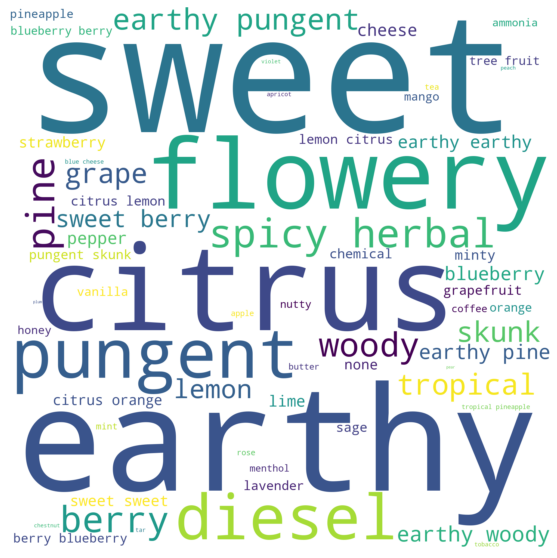

In [13]:
# create wordcloud visual
wordcloud = WordCloud(width = 2000, height = 2000, 
                background_color ='white', 
                max_words=100, 
                min_font_size = 10).generate(' '.join(cannabis['lemmatized_flavor']))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

As we can see, cannabis is highly diverse in its flavor profiles. A descriptor that popped out to me was coffee... I have never come across a cannabis strain that is coffee like, but nonetheless, doesn't mean it doesn't exist. 

Also, what the hell does diesel taste like? I guess I'm not up to speed with my cannabis flavor descriptors...

### Description

<AxesSubplot:title={'center':'Word Count Distribution for Cannabis strain descriptions'}, ylabel='Frequency'>

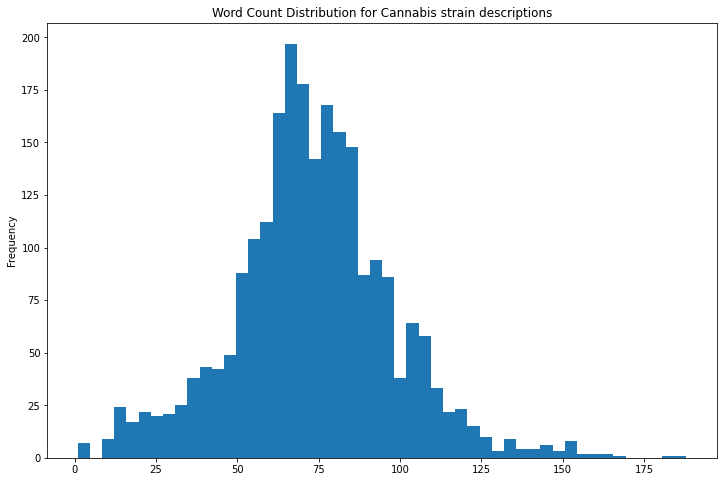

In [14]:
# Calculating the word count for the cannabis strain description
cannabis['word_count'] = cannabis['Description'].apply(lambda x: len(str(x).split()))

# Plotting the word count
cannabis['word_count'].plot(
    kind='hist',
    bins = 50,
    figsize = (12,8),title='Word Count Distribution for Cannabis strain descriptions')

<AxesSubplot:title={'center':'Bigram disribution for the top 20 words in the cannabis strain description'}, xlabel='bigram'>

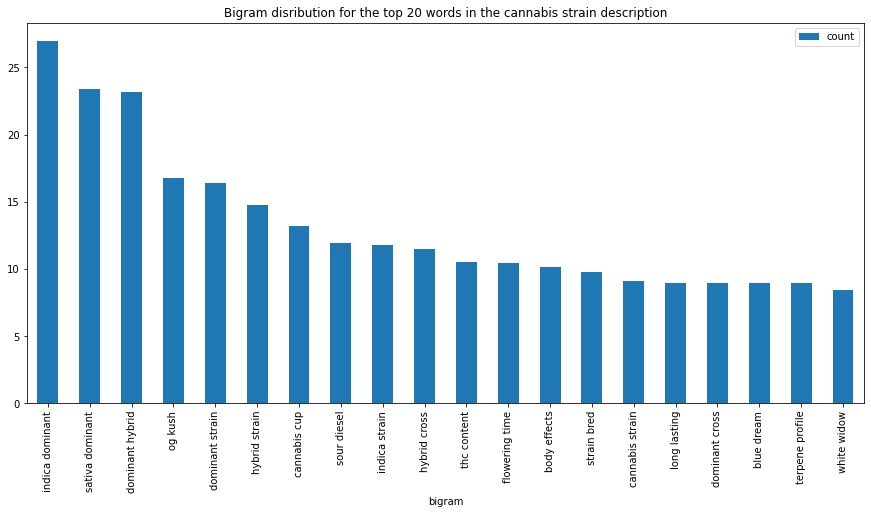

In [15]:
#Converting text descriptions into vectors using TF-IDF using Bigram
tf = TfidfVectorizer(ngram_range=(2, 2), stop_words='english')
tfidf_matrix = tf.fit_transform(cannabis['Description'])
total_words = tfidf_matrix.sum(axis=0) 

#Finding the word frequency
freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)

#converting into dataframe 
bigram = pd.DataFrame(freq)
bigram.rename(columns = {0:'bigram', 1: 'count'}, inplace = True) 

#Taking first 20 records
bigram = bigram.head(20)#Plotting the bigram distribution
bigram.plot(x ='bigram', y='count', kind = 'bar', title = "Bigram disribution for the top 20 words in the cannabis strain description", figsize = (15,7), )

<AxesSubplot:title={'center':'Trigram disribution for the top 20 words in the cannabis strain description'}, xlabel='trigram'>

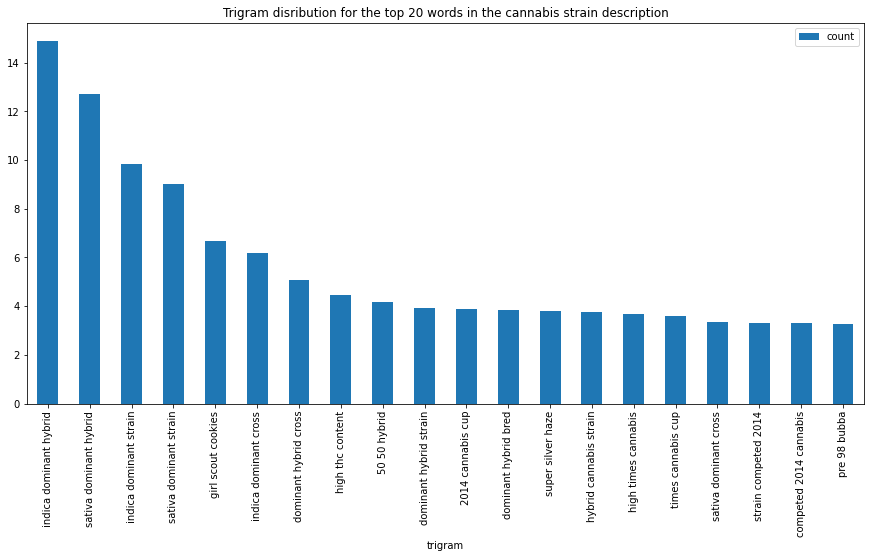

In [16]:
#Converting text descriptions into vectors using TF-IDF using Trigram
tf = TfidfVectorizer(ngram_range=(3, 3), stop_words='english')
tfidf_matrix = tf.fit_transform(cannabis['Description'])
total_words = tfidf_matrix.sum(axis=0)

#Finding the word frequency
freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)

#converting into dataframe 
trigram = pd.DataFrame(freq)
trigram.rename(columns = {0:'trigram', 1: 'count'}, inplace = True) 

#Taking first 20 records
trigram = trigram.head(20)#Plotting the trigramn distribution
trigram.plot(x ='trigram', y='count', kind = 'bar', title = "Trigram disribution for the top 20 words in the cannabis strain description", figsize = (15,7), )

In [17]:
#apply the lemmatizer to the description

cannabis['lemmatized_description'] = cannabis['Description'].apply(\
lambda x : ' '.join([lemmatizer.lemmatize(word.lower()) \
    for word in word_tokenize(re.sub(r'([^\s\w]|_)+', ' ', str(x)))]))

In [18]:
cannabis['lemmatized_description'][2]

'1024 is a sativa dominant hybrid bred in spain by medical seed co the breeder claim to guard the secret genetics due to security reason but regardless of it genetic heritage 1024 is a thc powerhouse with a sweet and spicy bouquet subtle fruit flavor mix with an herbal musk to produce uplifting sativa effect one specific phenotype is noted for having a pungent odor that fill a room similar to burning incense'

In [19]:
cannabis['Description'][2]

'1024 is a sativa-dominant hybrid bred in Spain by Medical Seeds Co. The breeders claim to guard the secret genetics due to security reasons, but regardless of its genetic heritage, 1024 is a THC powerhouse with a sweet and spicy bouquet. Subtle fruit flavors mix with an herbal musk to produce uplifting sativa effects. One specific phenotype is noted for having a pungent odor that fills a room, similar to burning incense.'

In [20]:
cannabis['Description'][15]

'Named after the telephone area code of the San Fernando Valley in Los Angeles, 818 OG is an OG Kush strain popular with patients for treating pain, loss of appetite, and insomnia. Not to be confused with the other OG cut named for the locale, the 818 OG has a very fruity flavor that is quite different from the sour, earthy fuel taste found in the SFV OG.\xa0'

### Recommender

In [21]:
# using lemmatized_text, create the corpus
corpus = cannabis['lemmatized_description']

# FEATURE EXTRACTION
# throw out any words used with 90% frequency or higher, throw out words that have been used less than 5 times
tfidf_model = TfidfVectorizer(max_features=100,
                              ngram_range=(2,3),
                              max_df=0.9,
                              min_df=0.05,
                              stop_words='english')

# define the matrix
tfidf_matrix = tfidf_model.fit_transform(corpus).todense()

tfidf_df = pd.DataFrame(tfidf_matrix)
tfidf_df.columns = sorted(tfidf_model.vocabulary_)
tfidf_df.head()

,body effect,cannabis cup,dominant hybrid,dominant strain,flowering time,hybrid cross,hybrid strain,indica dominant,indica dominant hybrid,indica dominant strain,indica strain,og kush,sativa dominant,sativa dominant hybrid,strain ha,terpene profile,thc content
0,0.737305,0.0,0.000000,0.0,0.0,0.0,0.675559,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2,0.000000,0.0,0.521943,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.523806,0.673203,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4,0.000000,0.0,0.548773,0.0,0.0,0.0,0.000000,0.500509,0.669581,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


In [22]:
#calculate the cosine similarity of the matrix
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

#Construct a reverse mapping of indices and beer names, and drop duplicate names, if any
indices = pd.Series(cannabis.index, index=cannabis['Strain']).drop_duplicates()

In [23]:
# Function that takes in beer name as input and gives recommendations 
def recommender(strain, cosine_sim=cosine_sim, df=cannabis, indices=indices):
    # Obtain the index of the beer that matches the name
    idx = indices[strain]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    canna_indices = [i[0] for i in sim_scores]

    
    return cannabis[['Strain', 'Type', 'Description']].iloc[canna_indices]

In [24]:
# print out results - Zamaldelica will be the guinea pig 
recommender('Zamaldelica')

,Strain,Type,Description
92,Alohaberry,hybrid,Originating from the tropical islands of Hawai...
116,Apollo-11,hybrid,Apollo 11 is a potent hybrid cannabis strain w...
128,Arjans-Strawberry-Haze,sativa,Arjan's Strawberry Haze was created by Arjan a...
155,Bc-Roadkill,hybrid,BC Roadkill is another strain that British Col...
185,Belladonna,hybrid,Belladonna is a mostly sativa strain that also...


In [30]:
print('Zamaldelica Description: ')
print(cannabis['Description'][2342])
print('')
print('RECOMMENDATIONS')
print('---------------------')
print('Alohaberry: ')
print(cannabis['Description'][92])
print('---------------------')
print('Apollo-11: ')
print(cannabis['Description'][116])
print('---------------------')
print('Arjans-Strawberry-Haze: ')
print(cannabis['Description'][128])
print('---------------------')
print('BC-Roadkill: ')
print(cannabis['Description'][155])
print('---------------------')
print('Belladonna: ')
print(cannabis['Description'][185])

Zamaldelica Description: 
Zamaldelica by Ace Seeds is a potent sativa-dominant strain from La Reunion Island near Madagascar. It is a cross of Zamal and Golden Tiger, and is famous for its heady, psychedelic effects and powerful physical vigor. The bright, spear-like colas are wrapped in red hairs and express a unique aroma of sweet carrot, mango, and citrus. This strain’s powerful mental effects leave the mind soaring and could overwhelm the uninitiated sativa consumer. Zamaldelica has an extended flowering period of approximately 11 to 14 weeks.  

RECOMMENDATIONS
---------------------
Alohaberry: 
Originating from the tropical islands of Hawaii, Alohaberry releases a pleasant aroma and taste of tropical berries. It is known for its unique sweet taste and because it is an equal hybrid, the effects are both mind and body. Flowering time for this plant is approximately 8-9 weeks.
---------------------
Apollo-11: 
Apollo 11 is a potent hybrid cannabis strain with strong cerebral effects

In [31]:
recommender('Bc-Roadkill')

,Strain,Type,Description
731,Early-Girl,indica,Early Girl is the wallflower of cannabis strai...
881,Gods-Treat,indica,"God’s Treat, bred from the holy matrimony of D..."
1187,King-Kong,hybrid,"King Kong, mothered by Ed Rosenthal Super Bud,..."
1662,Purple-Ak-47,hybrid,This slightly indica-dominant hybrid knocks ou...
1690,Purple-Gorilla,hybrid,"Purple Gorilla, named for its violet, oversize..."


In [32]:
print('BC Roadkill Description: ')
print(cannabis['Description'][155])
print('')
print('RECOMMENDATIONS')
print('---------------------')
print('Early Girl: ')
print(cannabis['Description'][731])
print('---------------------')
print('Gods-Treat: ')
print(cannabis['Description'][881])
print('---------------------')
print('King Kong: ')
print(cannabis['Description'][1187])
print('---------------------')
print('Purple AK47: ')
print(cannabis['Description'][1662])
print('---------------------')
print('Belladonna: ')
print(cannabis['Description'][1690])

BC Roadkill Description: 
BC Roadkill is another strain that British Columbia is proud to call their own. This top-shelf strain is rumored to be one of the stinkiest out there (though not in the same way that roadkill is). Growers love this strain for its consistent above average yields and 8 week flowering time. The flowers will be large and purple-blue with red hairs, and they typically reek of skunk and citrus. Its musky aroma is due to its BC Roadkill Skunk parent, which was bred with Deep Chunk to create this hybrid. Consumers also flock to scoop up this Roadkill for its strong buzz that is relaxing and trancey without being a complete knockout. Sleep may come easily, but so may euphoria and happy conversation, making this a daytime choice for many treating anxiety and stress.

RECOMMENDATIONS
---------------------
Early Girl: 
Early Girl is the wallflower of cannabis strains since its introduction in the 1980s. Lovingly preserved by the breeders at Sensi Seeds, this strain is laz

As a baseline, the recommendations make sense. 

The first test strain, Zamaldelica, is described as a strong sativa dominant strain. All the recommendations are just that - strong, sativa dominant strains. All are plausible recommendations for the end user given the descriptions in the dataset. 

Using BC-Roadkill as the other test item, it is described as having a strong buzz effect while not "being a knockout". The recommended strains have mostly the same effects - balanced yet relaxing effects. Another good result that makes sense.

More data, obviously, would be very useful to improve this recommender. Having user information would be beneficial as well. With user interaction data, a collaborative filter recommender could be built, or even a hybrid recommender. A Frequently Bought Together style recommender could also be built here, similar to Amazon's famous feature, but again, individual user interactions would be needed.

With more data, more complex models could be built like matrix factorization models or even the famous SVD algorithm could be used. The possibilities are almost endless in this case, but more data is needed to build something that could be considered "state of the art". 